# The Connor-Stevens model

The CS model belongs to the family of conductance-based neuron models. It is characterized by the presence of an additional potassium current, termed A-current, that affects the firing properties of the model. In particular, the CS model is a so-called type I neuron model, which indicates that the model can fire at arbitrarily low rates, while type II neuron models, such as the HH model, have a minimum firing rate below which they cannot fire.

The membrane current in the CS model is:

$I_m = g_L(V-E_L) + \bar{g}_{Na} m^3 h(V-E_{Na}) + \bar{g}_K n^4(V-E_K) + \bar{g}_A a^3 b(V-E_A)$

When membrane current is given in this form, the equation for the membrane voltage is

$C\frac{\mathrm{d}V_m}{\mathrm{d}t} + I_m = I_{app}$

The rate functions are given by the following equations:

$
\alpha_m(V_m) = 0.38 \frac{(V_m+29.7)}{1-\exp(-(V_m+29.7)/10)} \\
\beta_m(V_m) = 15.2 \exp(-0.0556(V_m+54.7)) \\
\alpha_h(V_m) = 0.266 \exp(-0.05(V_m+48)) \\
\beta_h(V_m) = \frac{3.8}{1+\exp(-0.1(V+18))} \\
\alpha_n(V_m) = 0.02 \frac{(V_m+45.7)}{1-\exp(-(V_m+45.7)/10)} \\
\beta_n(V_m) = 0.25 \exp(-0.0125(V_m+55.7))
$

while the dynamics of the $a$ and $b$ gating variables are described directly in terms of steady-state and time constant:

$
a_\infty(V_m) = \left(\frac{0.0761\exp(0.0314(V_m+94.22))}{1+exp(0.0346(V_m+1.17))} \right)^{1/3} \\
\tau_a(V_m) = 0.3632 + \frac{1.158}{1+\exp(0.0497(V_m+55.96))} \\
b_\infty(V_m) = \left(\frac{1}{1+\exp(0.0688(V_m+53.3))} \right)^4 \\
\tau_b(V_m) = 1.24 + \frac{2.678}{1+\exp(0.0624(V_m+50))} \\
$

The values of the constants are specified in the `CS` function below.

#### References
Connor, J.A. and Stevens, C.F., 1971. _Prediction of repetitive firing behaviour from voltage clamp data on an isolated neurone soma_. The Journal of physiology, 213(1), p.31. DOI: [10.1113/jphysiol.1971.sp009366](https://doi.org/10.1113/jphysiol.1971.sp009366).

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from hh_utils import vtrap, coeffs

Define the functions that describe the model:

In [2]:
cs_alphah = lambda v: 0.266 * np.exp(-0.05*(v+48))
cs_alpham = lambda v: 0.38 * vtrap(-(v+29.7), 10)
cs_alphan = lambda v: 0.02 * vtrap(-(v+45.7), 10)
cs_betah  = lambda v: 3.8 / (1 + np.exp(-0.1*(v+18)))
cs_betam  = lambda v: 15.2 * np.exp(-0.0556*(v+54.7))
cs_betan  = lambda v: 0.25 * np.exp(-0.0125*(v+55.7))
cs_ainf = lambda v: ((0.0761*np.exp(0.0314*(v+94.22)))/(1+np.exp(0.0346*(v+1.17))))**(1/3)
cs_taua = lambda v: 0.3632 + 1.158/(1+np.exp(0.0497*(v+55.96)))
cs_binf = lambda v: (1/(1+np.exp(0.0688*(v+53.3))))**4
cs_taub = lambda v: 1.24 + 2.678/(1+np.exp(0.0624*(v+50)))

def CS(t,x,I):
    C      =   1     # [μF/cm2]
    ENa    =  55     # [mV]
    EK     = -72     # [mV]
    EL     = -17     # [mV]
    EA     = -75     # [mV]
    gNabar =   1.2   # [mS/mm2]
    gKbar  =   0.2   # [mS/mm2]
    gL     =   0.003 # [mS/mm2]
    gAbar  =   0.477 # [mS/mm2]
    gNabar *= 100    # [mS/cm2]
    gKbar  *= 100    # [mS/cm2]
    gL     *= 100    # [mS/cm2]
    gAbar  *= 100    # [mS/cm2]
    f = np.zeros(6)
    v,m,h,n,a,b = x
    minf,taum = coeffs(v, cs_alpham, cs_betam)
    hinf,tauh = coeffs(v, cs_alphah, cs_betah)
    ninf,taun = coeffs(v, cs_alphan, cs_betan)
    ainf,taua = cs_ainf(v), cs_taua(v)
    binf,taub = cs_binf(v), cs_taub(v)
    f[0] = (gL*(EL-v) + gNabar*m**3*h*(ENa-v) + gKbar*n**4*(EK-v) + gAbar*a**3*b*(EA-v) + I) / C
    f[1] = (minf-m)/taum
    f[2] = (hinf-h)/tauh
    f[3] = (ninf-n)/taun
    f[4] = (ainf-a)/taua
    f[5] = (binf-b)/taub
    return f

Like we did for the HH model, here we plot the steady-state and time constant functions:

In [3]:
Vm = np.r_[-100 : 50]
minf,taum = coeffs(Vm, cs_alpham, cs_betam)
hinf,tauh = coeffs(Vm, cs_alphah, cs_betah)
ninf,taun = coeffs(Vm, cs_alphan, cs_betan)
ainf,taua = cs_ainf(Vm), cs_taua(Vm)
binf,taub = cs_binf(Vm), cs_taub(Vm)

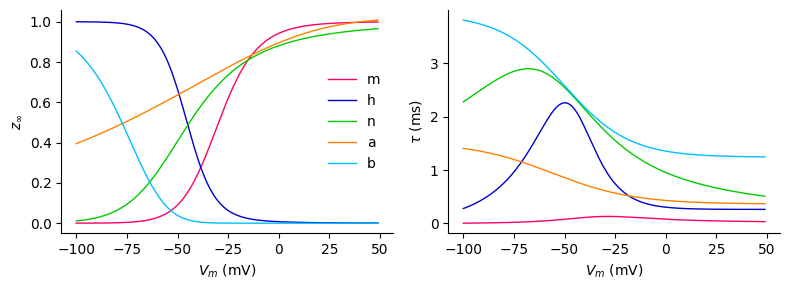

In [4]:
fig,ax = plt.subplots(1, 2, figsize=(8,3), sharex=True)
cmap = {'m': [1,0,.4], 'n': [0,.8,0], 'h': [0,0,.8], 'a': [1,.5,0], 'b': [0,0.75,1]}
ax[0].plot(Vm, minf, color=cmap['m'], lw=1, label='m')
ax[0].plot(Vm, hinf, color=cmap['h'], lw=1, label='h')
ax[0].plot(Vm, ninf, color=cmap['n'], lw=1, label='n')
ax[0].plot(Vm, ainf, color=cmap['a'], lw=1, label='a')
ax[0].plot(Vm, binf, color=cmap['b'], lw=1, label='b')
ax[1].plot(Vm, taum, color=cmap['m'], lw=1)
ax[1].plot(Vm, tauh, color=cmap['h'], lw=1)
ax[1].plot(Vm, taun, color=cmap['n'], lw=1)
ax[1].plot(Vm, taua, color=cmap['a'], lw=1)
ax[1].plot(Vm, taub, color=cmap['b'], lw=1)
ax[0].legend(loc='right', frameon=False)
for a in ax:
    a.set_xlabel(r'$V_m$ (mV)')
ax[0].set_ylabel(r'$z_\infty$')
ax[1].set_ylabel(r'$\tau$ (ms)')
sns.despine()
fig.tight_layout()

Integrate the system for a given value of injected current:

In [5]:
I = 8.7
tspan = [0,300]
Vm0 = -65
minf,_ = coeffs(Vm0, cs_alpham, cs_betam)
hinf,_ = coeffs(Vm0, cs_alphah, cs_betah)
ninf,_ = coeffs(Vm0, cs_alphan, cs_betan)
ainf,binf = cs_ainf(Vm0), cs_binf(Vm0)
x0 = [Vm0, minf, hinf, ninf, ainf, binf]
sol = solve_ivp(CS, tspan, x0, method='BDF', args=(I,), rtol=1e-6, atol=1e-8)

Plot the results:

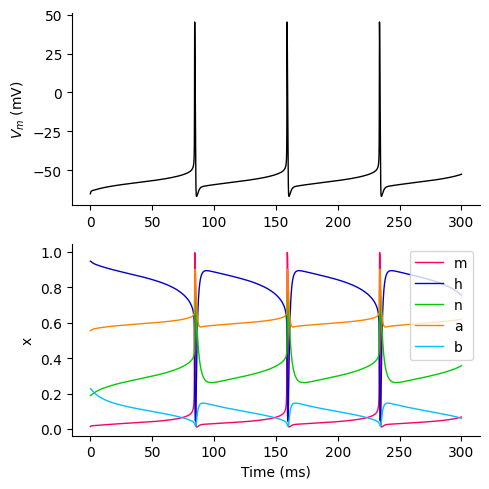

In [6]:
cmap = {'m': [1,0,.4], 'n': [0,.8,0], 'h': [0,0,.8], 'a': [1,.5,0], 'b': [0,0.75,1]}
fig,ax = plt.subplots(2, 1, figsize=(5,5))
ax[0].plot(sol.t, sol.y[0], 'k', lw=1)
ax[0].set_ylabel(r'$V_m$ (mV)')
for i,var_name in enumerate('mhnab'):
    ax[1].plot(sol.t, sol.y[i+1], color=cmap[var_name], lw=1, label=var_name)
ax[1].set_ylabel('x')
ax[1].legend(loc='best')
ax[-1].set_xlabel('Time (ms)')
sns.despine()
fig.tight_layout()

#### Exercises

1. Compute the f-I curve of the CS model.
1. Show how the f-I curve is modified by the presence or absence of the A-type current.